<a href="https://www.kaggle.com/code/nicksv03/age-gender-detection?scriptVersionId=134928869" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(False)
from tensorflow import keras
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Importing Data

Converting our dataset into TFRecord files. 

In [2]:
maindir = "/kaggle/input/utkface-new/UTKFace"
files = os.listdir(maindir)
size = len(files)
print('total files:', size)

total files: 23708


In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
np.random.shuffle(files)

In [5]:
files[0]

'85_0_0_20170111210408610.jpg.chip.jpg'

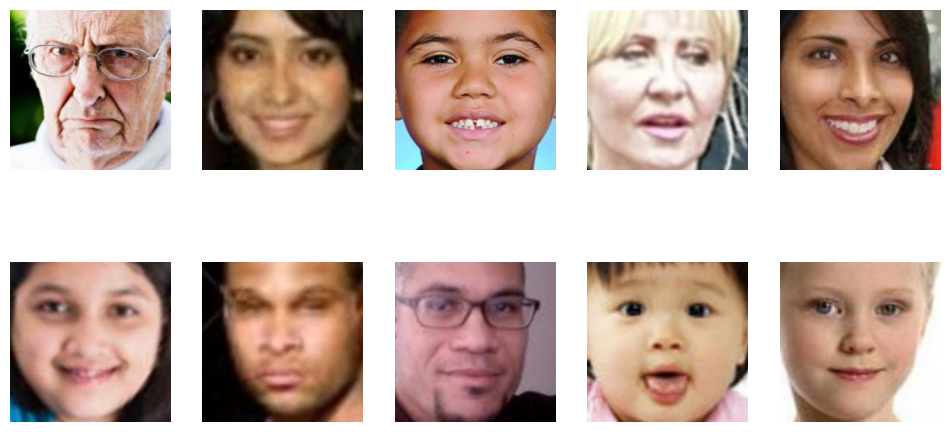

In [6]:
fig, ax = plt.subplots(2,5, figsize=(12, 6), sharex=True, sharey=True)
for image_idx in range(10):
    ax[image_idx//5, image_idx%5].imshow(Image.open(os.path.join(maindir,files[image_idx])))
    ax[image_idx//5, image_idx%5].axis('off')
plt.show()

In [7]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

In [9]:
def create_example(folder_path, filepath):
    full_path = os.path.join(folder_path, filepath)
    image = tf.io.serialize_tensor(np.array(Image.open(full_path)))
    split = filepath.split('_')
    age = int(split[0])
    gender = int(split[1])

    example = Example(
        features=Features(
            feature={
                'image': Feature(bytes_list=BytesList(value=[image.numpy()])),
                'age': Feature(int64_list=Int64List(value=[age])),
                'gender': Feature(int64_list=Int64List(value=[gender])),
            }
        )
    )
    return example

In [10]:
def create_tf_record(set_, filename):
    with tf.io.TFRecordWriter('%s.tfrecord' % filename) as f:
        for filepath in set_:
            if filepath != 'utkcropped':
                example = create_example(maindir, filepath)
                f.write(example.SerializeToString())

In [ ]:
train_range = [i for i in range (0,16596)]
valid_range = [i for i in range (16597, 18968)]
test_range = [i for i in range (18969, len(files)+1)]

In [11]:
create_tf_record(files[:16597], 'train_set')

In [12]:
create_tf_record(files[16597:18968], 'valid_set')

In [14]:
create_tf_record(files[18968:], 'test_set')

# Preprocessing

In [15]:
@tf.function
def preprocess(tfrecord):
    feature_descriptions = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'age': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        'gender': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example['image'], out_type=tf.uint8)
    image = tf.reshape(image, shape=[200, 200, 3])
    image = tf.image.resize(image, [224, 224])
    image = keras.applications.xception.preprocess_input(image)
    return image, example['age'], example['gender']

def utkface_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                    n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [16]:
train_data = utkface_dataset('/kaggle/working/train_set.tfrecord')
valid_data = utkface_dataset('/kaggle/working/valid_set.tfrecord')
test_data = utkface_dataset('/kaggle/working/test_set.tfrecord')

The data is now converted into TFRecord format.

Let's use a pretrained model to gender and age

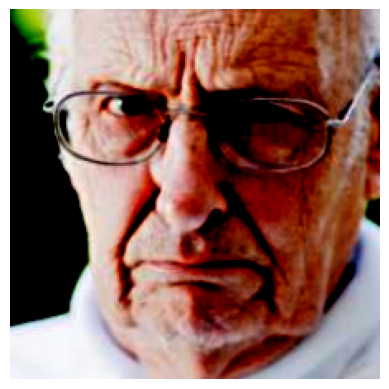

I am 85 years old! 0


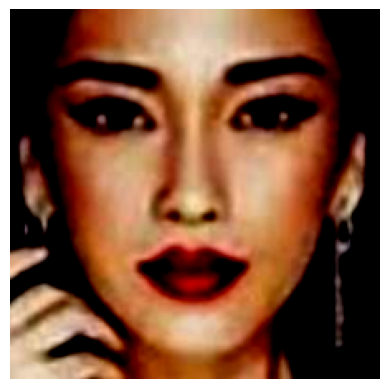

I am 25 years old! 1


In [17]:
for image, age, gender in train_data.take(2):
    plt.imshow(image[0])
    plt.axis('off')
    plt.show()
    print('I am', age[0].numpy(), 'years old!',gender[0].numpy())

# Transfer Learning with XCeption

### Model Architecture

In [18]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
age_output = keras.layers.Dense(1, activation='relu', name='age')(avg)
gender_output = keras.layers.Dense(1, activation='sigmoid', name='gender')(avg)

model = keras.models.Model(inputs=base_model.input, outputs=[age_output, gender_output])

83683744/83683744 [==============================] - 0s 0us/step


In [19]:
# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
optimizer = keras.optimizers.Nadam(learning_rate=1e-4)
model.compile(loss=['mean_squared_error', 'binary_crossentropy'],
              optimizer=optimizer,
              loss_weights=[1.0, 0.5],
              metrics=['accuracy'])

history = model.fit(train_data, 
                    validation_data=valid_data,
                   epochs = 15)

Epoch 1/15
519/519 [==============================] - 57s 90ms/step - loss: 462.9100 - age_loss: 501.7764 - gender_loss: -77.7327 - age_accuracy: 0.0442 - gender_accuracy: 0.0461 - val_loss: 300.6619 - val_age_loss: 376.2858 - val_gender_loss: -151.2480 - val_age_accuracy: 0.0426 - val_gender_accuracy: 0.0426
Epoch 2/15
519/519 [==============================] - 45s 86ms/step - loss: 204.1930 - age_loss: 317.7624 - gender_loss: -227.1388 - age_accuracy: 0.0478 - gender_accuracy: 0.0478 - val_loss: 110.3554 - val_age_loss: 259.7505 - val_gender_loss: -298.7903 - val_age_accuracy: 0.0426 - val_gender_accuracy: 0.0426
Epoch 3/15
519/519 [==============================] - 50s 96ms/step - loss: 44.8444 - age_loss: 232.9776 - gender_loss: -376.2663 - age_accuracy: 0.0478 - gender_accuracy: 0.0478 - val_loss: -17.4014 - val_age_loss: 205.7366 - val_gender_loss: -446.2760 - val_age_accuracy: 0.0426 - val_gender_accuracy: 0.0426
Epoch 4/15
519/519 [==============================] - 50s 96ms/ste

In [ ]:
# Unfreeze the weights and continue training
for layer in base_model.layers:
    layer.trainable = True
    
# Training the Model
checkpoint_callback = keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)
early_stopping_callback = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=100,
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/100
519/519 [==============================] - 46s 88ms/step - loss: -1357.4614 - age_loss: 97.6500 - gender_loss: -2910.2231 - age_accuracy: 0.0126 - gender_accuracy: 0.0478 - val_loss: -1375.9958 - val_age_loss: 100.4145 - val_gender_loss: -2952.8208 - val_age_accuracy: 0.0114 - val_gender_accuracy: 0.0426
Epoch 2/100
519/519 [==============================] - 51s 97ms/step - loss: -1433.4822 - age_loss: 96.1560 - gender_loss: -3059.2764 - age_accuracy: 0.0117 - gender_accuracy: 0.0478 - val_loss: -1451.1987 - val_age_loss: 98.9321 - val_gender_loss: -3100.2625 - val_age_accuracy: 0.0110 - val_gender_accuracy: 0.0426
Epoch 3/100
519/519 [==============================] - 50s 97ms/step - loss: -1509.3855 - age_loss: 94.7773 - gender_loss: -3208.3281 - age_accuracy: 0.0114 - gender_accuracy: 0.0478 - val_loss: -1526.2887 - val_age_loss: 97.5627 - val_gender_loss: -3247.7024 - val_age_accuracy: 0.0101 - val_gender_accuracy: 0.0426
Epoch 4/100
519/519 [===========================

In [ ]:
model = keras.models.load_model('model.h5')

In [ ]:
rmse, accuracy = model.evaluate(test_data)
print("RMSE for Test Data: %.3f" % rmse[0])
print("Accuracy for Gender Prediction: %.3f" % accuracy[1])